In [46]:
from astropy.stats import kuiper_two

In [47]:
#General imports.
import ROOT as r
import math
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
r.gStyle.SetOptStat(0)
r.gStyle.SetOptFit(1111)
import matplotlib.pyplot as plt
import csv
import pandas

import seaborn as sns
sns.set(style="ticks", color_codes=True)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
import os
import scipy

import uproot # https://indico.cern.ch/event/686641/contributions/2894906/attachments/1606247/2548596/pivarski-uproot.pdf
from awkward import JaggedArray
from root_pandas import read_root # https://github.com/scikit-hep/root_pandas

import warnings
warnings.filterwarnings('once')

%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'

In [48]:
f = r.TFile("./data/energy_time_60hr_most.root")
f.ls()

TFile**		./data/energy_time_60hr_most.root	
 TFile*		./data/energy_time_60hr_most.root	
  KEY: TCanvas	c1;1	c1


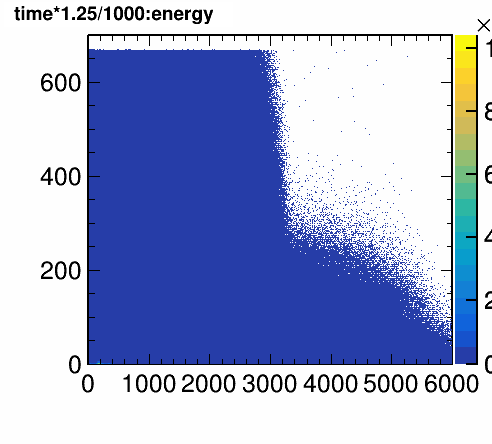

In [49]:
c1 = f.Get("c1")
c1.Draw()

In [50]:
c1.GetListOfPrimitives().Print()

Collection name='TList', class='TList', size=3
 TFrame  X1=0.000000 Y1=0.000000 X2=6000.000000 Y2=700.000000 Width=2 FillColor=10 FillStyle=1001
 TH1.Print Name  = hist, Entries= -2147483648, Total sum= 7.90641e+09
 TPaveText  X1=-1378.378419 Y1=718.037107 X2=2396.469016 Y2=770.945948 Width=2 FillStyle=1001
 Collection name='TList', class='TList', size=1
  Text  X=0.000000 Y=0.000000 Text=time*1.25/1000:energy Font=0 Size=0.000000 Color=0 Align=0


In [51]:
h = c1.GetPrimitive("hist").Clone()
h.SetDirectory(0)
print(h)

<ROOT.TH2F object ("hist") at 0x7fc45d48fbe0>


In [52]:
print(h.GetNbinsX(),h.GetNbinsY())
print(h.GetXaxis().GetXmin(), h.GetXaxis().GetXmax())
print(h.GetYaxis().GetXmin(), h.GetYaxis().GetXmax())

6000 4700
0.0 6000.0
0.0 700.0


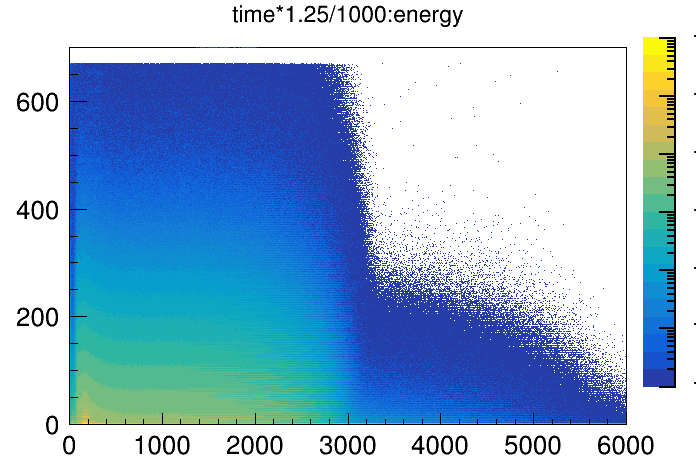

In [53]:
c2 = r.TCanvas()
h.Draw("COLZ")
c2.SetLogz()
c2.Draw()

f = r.TFile("./data/gm2offline_ana.root")
f.cd("farline/calo1")
#f.ls()

c = r.TCanvas()
evt = f.Get("farline").Get("calo1").Get("energy_vs_time").Clone()
for calo in range(2,25):
    evt2 = f.Get("farline").Get("calo"+str(calo)).Get("energy_vs_time").Clone()
    evt.Add(evt2,1)
evt.Draw("colz")
c.SetLogz()
c.Draw()

evt.Reset()
evt.Add(h,1)

In [54]:
evt = h.Clone()

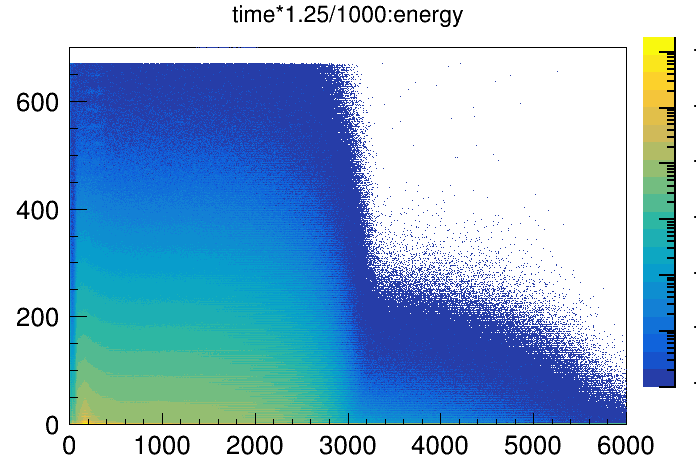

In [78]:
c2 = r.TCanvas()
evt.Draw("COLZ")
evt.Rebin2D(1,2)
c2.SetLogz()
c2.Draw()

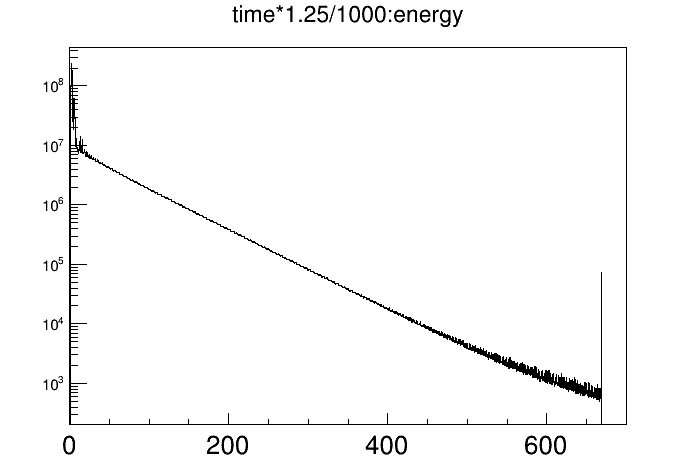

In [79]:
c2 = r.TCanvas()
evt.GetXaxis().SetRangeUser(0,700)
evt_time = evt.ProjectionY().Clone()
evt_time.Draw("COLZ")
c2.SetLogy()
c2.Draw()

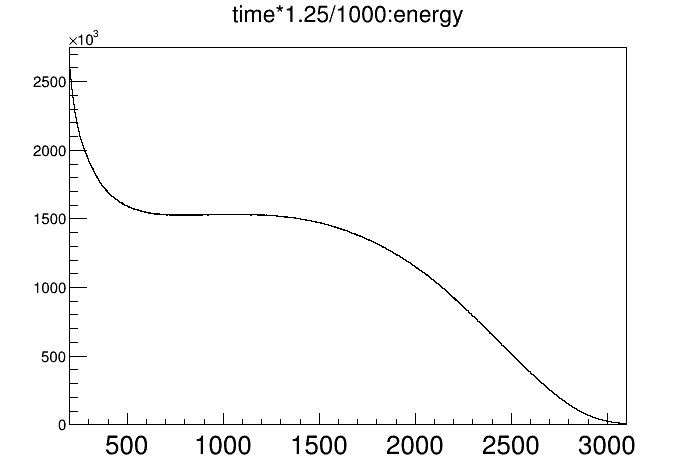

In [80]:
c2 = r.TCanvas()
e1 = 200 #200 and 3100 produced a stable result in the visualizer
e2 = 3100
t1 = 30
t2 = 650

t1global = t1
t2global = t2 

evt.GetXaxis().SetRangeUser(e1,e2)
evt.GetYaxis().SetRangeUser(30,600)

cuti = r.TCutG("cuti")
cuti.SetPoint(0,e1,t1)
cuti.SetPoint(1,e2,t1)
cuti.SetPoint(2,e2,t2)
cuti.SetPoint(3,e1,t2)
cuti.SetPoint(4,e1,t1)

h = evt.ProjectionX("h",0,-1,"[cuti]").Clone()
#h.Scale(1/(h.GetEntries()))
h.Draw()
c2.Draw()

In [81]:
timeBinWidth = evt_time.GetBinWidth(100)
timeBinCenters = []
for i in range(evt_time.GetNbinsX()):
    binCenter = evt_time.GetBinCenter(i)
    if(binCenter > t1 and binCenter < t2):
        timeBinCenters.append(binCenter)

In [82]:
timeBinCenters[:10]

[30.23404255319149,
 30.53191489361702,
 30.829787234042552,
 31.127659574468087,
 31.425531914893618,
 31.72340425531915,
 32.02127659574468,
 32.31914893617021,
 32.61702127659574,
 32.91489361702127]

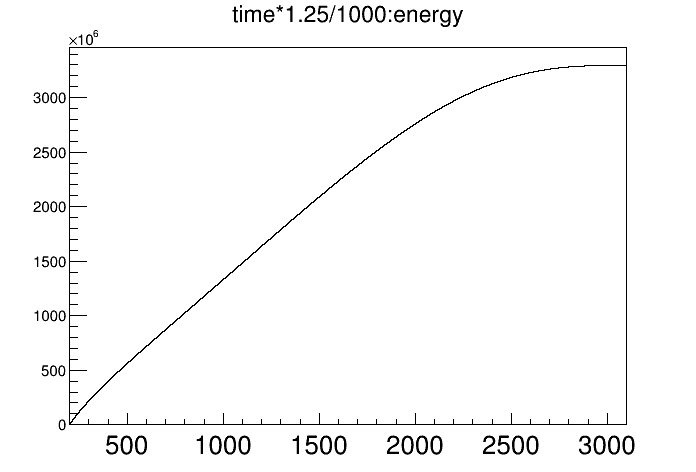

In [83]:
hcum = h.GetCumulative()
c2 = r.TCanvas()
hcum.Draw()
c2.Draw()

In [84]:
hscaled = h.Clone("hscaled")
hscaled.Scale(1/(hscaled.GetEntries()))

In [85]:
ndivs = len(timeBinCenters)
numberOfBins = 2
print(ndivs)
timeSlices = []
timeSlicesCum = []
times = []
for div in range(ndivs):
    t1 = timeBinCenters[div] - timeBinWidth*numberOfBins
    t2 = timeBinCenters[div] + timeBinWidth*numberOfBins
    evt.GetYaxis().SetRangeUser(t1,t2)
    
    cuti = r.TCutG("cuti")
    cuti.SetPoint(0,e1,t1)
    cuti.SetPoint(1,e2,t1)
    cuti.SetPoint(2,e2,t2)
    cuti.SetPoint(3,e1,t2)
    cuti.SetPoint(4,e1,t1)

    htemp = evt.ProjectionX("htemp",0,-1,"[cuti]").Clone()
    htemp.SetTitle("EvT Projection from Time Slice "+str(t1).zfill(3)+" - "+str(t2).zfill(3))
    htemp.Scale(1/(htemp.GetEntries()))
    
    timeSlices.append(htemp.Clone("h"+str(div+1)))
    timeSlicesCum.append(htemp.GetCumulative().Clone("hcum"+str(div+1)))
    times.append(t1)

2081


In [86]:
hscaledcum = hcum.Clone("hscaledcum")
#hscaled.Scale(1/(hscaled.GetEntries()))

for div in range(500):#ndivs):
    hprint = timeSlicesCum[div].Clone("hprint")
    #hprint.Scale(1/(hprint.GetEntries()))
    c = r.TCanvas("c","c",1000,1000)
    hscaledcum.Draw("HIST")
    hprint.SetLineColor(2)
    hprint.Draw("HIST SAME")
    #hscaled.GetXaxis().SetRangeUser(0.0001,0.01)
    c.SetLogy()
    c.Draw()
    #c.Print("./images/evt_cum_"+str(div).zfill(5)+".png")

In [87]:
ks = []
for i, hslice in enumerate(timeSlicesCum):
    ksi = hcum.KolmogorovTest(hslice,"M")
    ks.append(ksi)

print(ks)

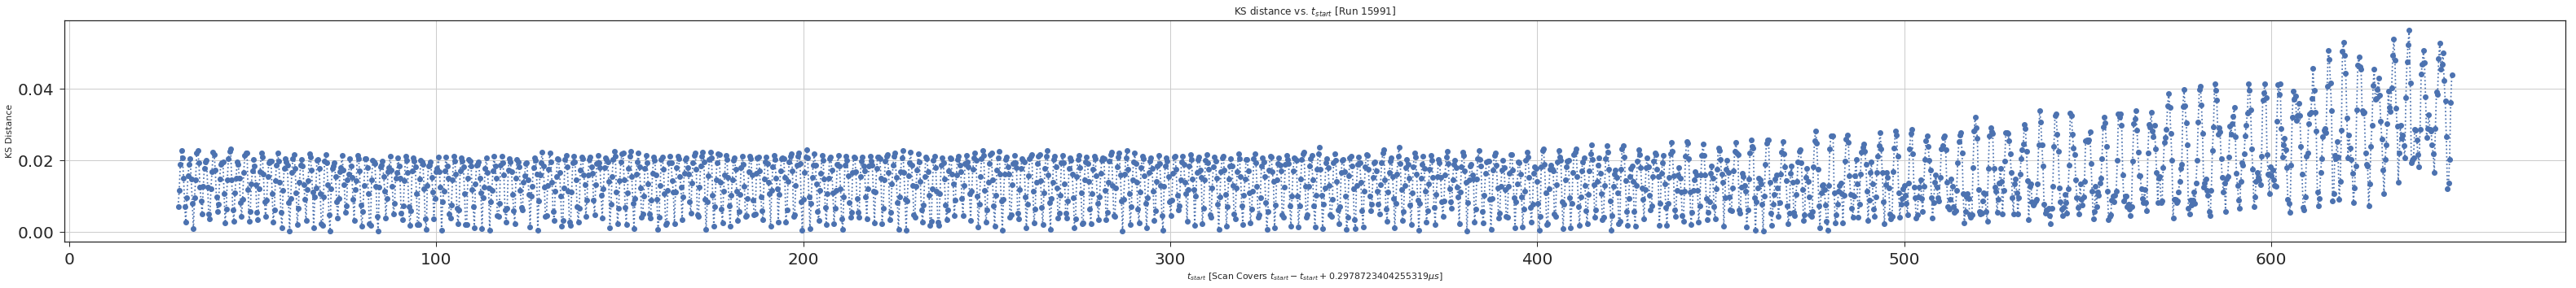

In [88]:
fig, ax = plt.subplots(figsize=(55,5))
plt.plot(times,ks,':o')
plt.title(r"KS distance vs. $t_{start}$ [Run 15991]")
plt.xlabel(r"$t_{start}$ [Scan Covers $t_{start} - t_{start} + "+str(timeBinWidth)+r" \mu s$]")
plt.ylabel("KS Distance")
plt.grid()
plt.show()

---


### Now lets look for the Kuiper Statistic for these same data

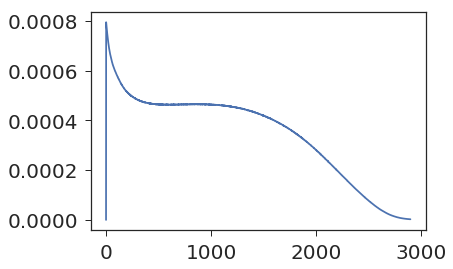

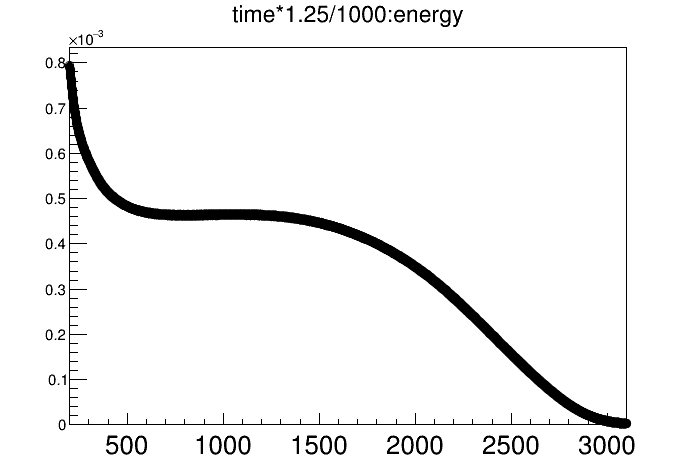

In [89]:
c = r.TCanvas()
hscaled.Draw()
c.Draw()

refVec = []
for i in range(hscaled.GetNbinsX()):
    binc = hscaled.GetBinContent(i)
    refVec.append(binc)
    
plt.plot(refVec)
#plt.yscale('log')
plt.show()

In [90]:
kuiper = []
for i, hslice in enumerate(timeSlices):
    compVec = []
    for i in range(hslice.GetNbinsX()):
        binc = hslice.GetBinContent(i)
        compVec.append(binc)
        
    ksi, pkuiper = kuiper_two(refVec, compVec)
    
    kuiper.append(ksi)

/home/jlab/anaconda3/lib/python3.6/site-packages/astropy/stats/funcs.py:1302: RuntimeWarning: invalid value encountered in double_scalars
  term = T(t) * comb(N, t) * (1 - D - t / float(N))**(N - t - 1)


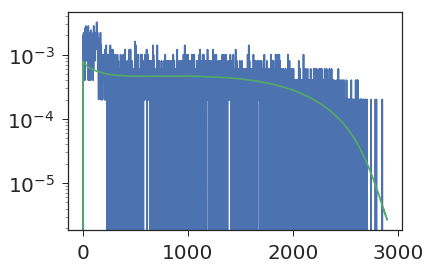

In [91]:
plt.plot(compVec)
plt.plot(refVec)
plt.yscale('log')
plt.show()

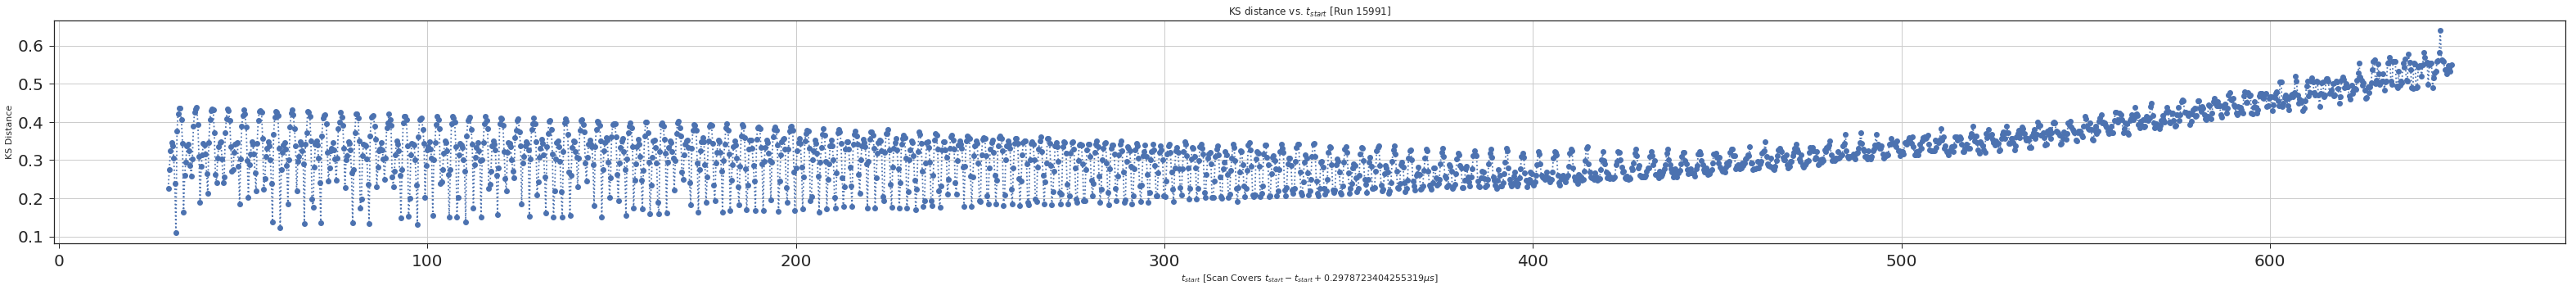

In [92]:
fig, ax = plt.subplots(figsize=(55,5))
plt.plot(times,kuiper,':o')
plt.title(r"KS distance vs. $t_{start}$ [Run 15991]")
plt.xlabel(r"$t_{start}$ [Scan Covers $t_{start} - t_{start} + "+str(timeBinWidth)+r" \mu s$]")
plt.ylabel("KS Distance")
plt.grid()
plt.show()

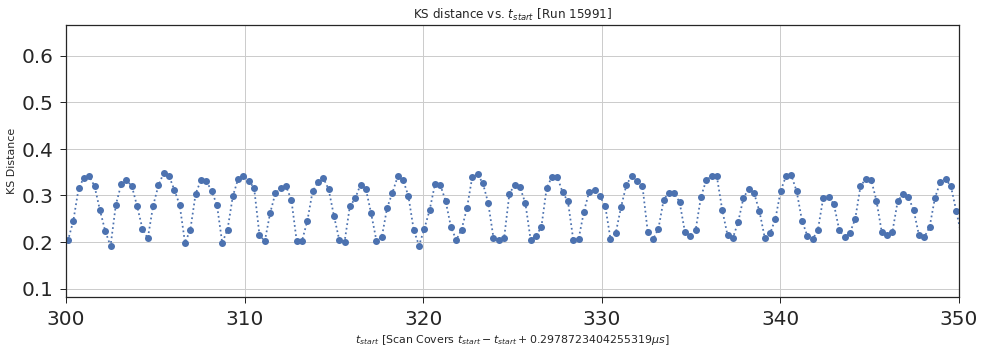

In [93]:
fig, ax = plt.subplots(figsize=(16,5))
plt.plot(times,kuiper,':o')
plt.title(r"KS distance vs. $t_{start}$ [Run 15991]")
plt.xlabel(r"$t_{start}$ [Scan Covers $t_{start} - t_{start} + "+str(timeBinWidth)+r" \mu s$]")
plt.ylabel("KS Distance")
plt.grid()
plt.xlim(300,350)
plt.show()

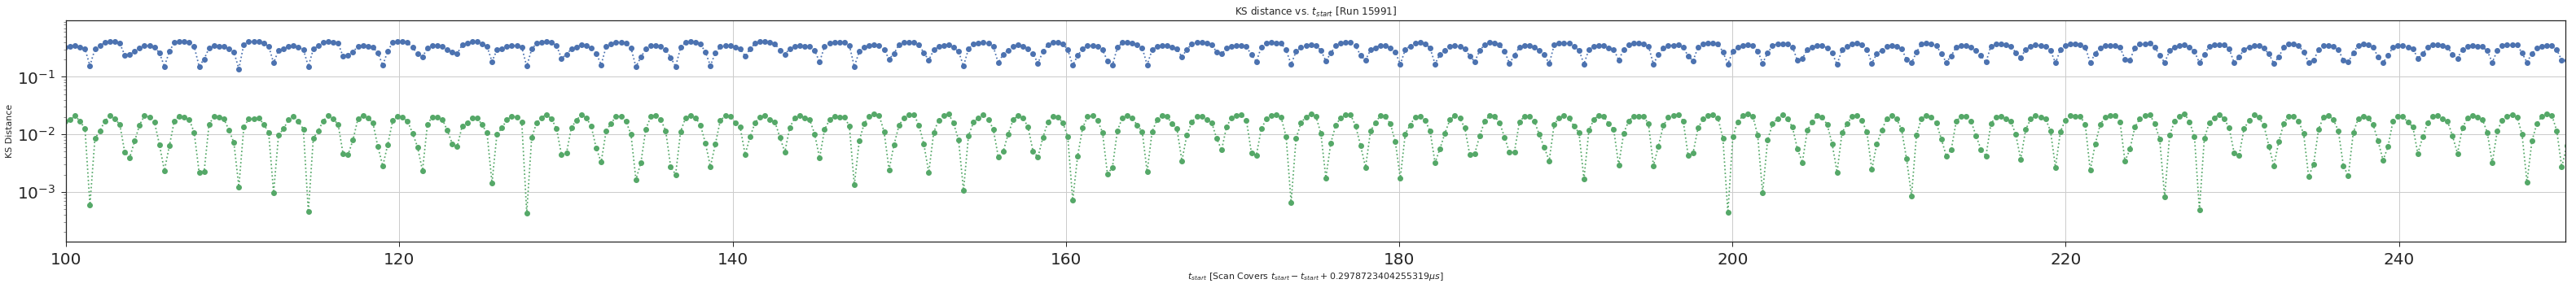

In [94]:
fig, ax = plt.subplots(figsize=(55,5))
plt.plot(times,kuiper,':o')
plt.plot(times,ks,':o')
plt.title(r"KS distance vs. $t_{start}$ [Run 15991]")
plt.xlabel(r"$t_{start}$ [Scan Covers $t_{start} - t_{start} + "+str(timeBinWidth)+r" \mu s$]")
plt.ylabel("KS Distance")
plt.yscale('log')
plt.xlim(100,250)
plt.grid()
plt.show()